In [1]:
import pandas as pd
import numpy as np
import os
import datetime
import math
import sklearn
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
import warnings
warnings.filterwarnings('ignore')

## Price History Table
Here is the price table we used for this function.

In [49]:
# data as a training data.
training_set = pd.read_csv("data_trade.csv")
pairs_list = [['9020 JT', '9022 JT'], ['8801 JT', '8802 JT']]


In [50]:
for i in range(len(pairs_list)):
    if i==0:
        training_pair_set = \
            training_set.loc[training_set['ticker']==pairs_list[0][0]]
        training_pair_set = pd.concat([training_pair_set, 
                   training_set.loc[training_set['ticker']==pairs_list[0][1]]])
    else:
        training_pair_set = pd.concat([training_pair_set,
                   training_set.loc[training_set['ticker']==pairs_list[i][0]]])
        training_pair_set = pd.concat([training_pair_set,
                   training_set.loc[training_set['ticker']==pairs_list[i][1]]])

training_pair_set = training_pair_set.reset_index()
training_pair_set = training_pair_set.drop(columns=['index'])
#print(training_pair_set)
training_pair_set.head()


,ticker,2017-08-16,2017-08-17,2017-08-18,2017-08-21,2017-08-22,2017-08-23,2017-08-24,2017-08-25,2017-08-28,...,2024-02-21,2024-02-22,2024-02-26,2024-02-27,2024-02-28,2024-02-29,2024-03-01,2024-03-04,2024-03-05,2024-03-06
0,9020 JT,9484.69,9379.81,9311.41,9329.65,9206.53,9215.65,9129.01,9119.89,9156.37,...,8955.0,9020.0,9043.0,8912.0,8850.0,8865.0,8914.0,8784.0,8788.0,8793.0
1,9022 JT,3510.92,3502.34,3471.84,3471.84,3451.83,3461.36,3464.22,3454.69,3471.84,...,3775.0,3803.0,3825.0,3779.0,3761.0,3769.0,3767.0,3735.0,3794.0,3795.0
2,8801 JT,2115.71,2111.31,2076.52,2074.76,2089.29,2078.72,2092.37,2083.12,2087.09,...,4051.0,4129.0,4140.0,4103.0,4015.0,4061.0,4144.0,4234.0,4220.0,4275.0
3,8802 JT,1745.44,1733.42,1695.57,1695.57,1706.26,1704.47,1689.33,1679.98,1676.42,...,2120.0,2178.0,2184.0,2230.5,2322.0,2300.5,2397.0,2423.5,2428.5,2465.5


## Create the spread funtion (price pair's relation)
We will create the function of spread in here. The basic function of spread is defined as blow:

$Spread = log(a) - nlog(b)$

where the 'a' and 'b' are prices of stocks A and B respectively and the 'n' is hedge ratio. Our target is finding dynamics of spread based on the machine learning. We will use the supervised machine learning to implement this part and the possible candidates are 'linear regression' and 'support vector machine (SVM)'

In [51]:
def create_spread_function(a, b, start_t, end_t, alg='log'):
    """
    Apply the supervised machine learning to find the dynamics of spread

    Args:
        a, b: Stock A and B's price history
        start_t, end_t: start/end time of the analysis on the data. 
            They use the same unit with the data. For example, 0 means the 
            first data of the a and b. 
            (Analyze the data from a[start_t], b[start_t] to a[end_t], 
            b[end_t])
        alg: Type of algorithm. The 'log' means the log normalization
    Return:
        spread_func: The function of spread. 
            Output of this function is spread and z_score.
    """
    
    def log_spread_func(a, b):
        """
        Calculate the spread and z-score based on the log spread function.
        
        Args:
            a, b: Current stocks' prices
        Return:
            spread: The relation between a and b
            z-score: Normalized relation between a and b 
        """

        spread = math.log(b) - w_avg * math.log(a)
        z_score = spread/w_std

        return (spread, z_score)


    def lr_spread_func(a, b):
        """
        Calculate the spread and z-score based on the linear regression.
        
        Args:
            a, b: Current stocks' prices
        Return:
            spread: The relation between a and b
            z-score: Normalized relation between a and b 
        """

        # Change the a to polynomial form
        a, b = np.log(a), np.log(b)
        a = a * np.ones((1, 1))
        poly = PolynomialFeatures(degree = best_degree)
        a = poly.fit_transform(a)

        # Calculate the spread & z_score
        spread = b - regr.predict(a)
        z_score = spread/spread_std

        return (spread, z_score)

    # Slice the date
    target_a = a[start_t:end_t]
    target_b = b[start_t:end_t]

    # use the log function
    target_a = np.log(target_a)
    target_b = np.log(target_b)
    
    total_date = end_t-start_t

    # Find the coefficient of the log normalization
    if alg == 'log':

        # Calculate the weight
        w_list = target_b/target_a
        w_avg = np.average(w_list)

        # Calculate the standard deviation for the z-score calculation
        w_std = np.std(w_list)

        return log_spread_func

    # Find the coefficient of the linear regression
    elif alg == 'lr':

        # Initialization
        min_cv_n = float("inf")
        best_degree = 0
        total_len = target_a.size

        # Permute the a and b for training dataset & validation dataset
        permute_order = np.random.permutation(total_len)
        target_a = target_a[permute_order]
        target_b = target_b[permute_order]

        # Divide to train and validation datasets
        train_num = int(target_a.size/3*2)

        train_a = target_a[:train_num]
        train_b = target_b[:train_num]
        valid_a = target_a[train_num:]
        valid_b = target_b[train_num:]

        # Change the datasets from 1-D to 2-D
        train_a = train_a[:, np.newaxis]
        valid_a = valid_a[:, np.newaxis]

        # Find the best degree
        for degree in range(1, 10, 1):
            # Change the train datasets to polynomial form
            poly = PolynomialFeatures(degree = degree)
            poly_train_a = poly.fit_transform(train_a)
            poly_valid_a = poly.fit_transform(valid_a)

            # Train the model with Lasso linear regression
            # We used the Lasso instead fo Ridge because it's better
            # https://hackernoon.com/practical-machine-learning-ridge-regression-vs-lasso-a00326371ece
            regr = linear_model.LassoCV(cv=5)
            regr.fit(poly_train_a, train_b)

            # Calculate the error
            cv_n = np.average((valid_b - regr.predict(poly_valid_a))**2)

            # Check the best degree
            if cv_n < min_cv_n:
                best_degree = degree
                min_cv_n = cv_n

        if best_degree == 0:
            print("Cross-validation error")

        # Train again with the best degree
        poly = PolynomialFeatures(degree=best_degree)
        poly_train_a = poly.fit_transform(train_a)
        regr = linear_model.LassoCV(cv=5)
        regr.fit(poly_train_a, train_b)
        
        # Calculate the standard deviation of spread for the z-score calculation
        b_pred = regr.predict(poly_train_a)
        spread = train_b - b_pred
        spread_std = np.std(spread)

        return lr_spread_func


    print("Check the algorithm. Input was " + alg)

    pass

### How to use

Here, we will see how to use the spread function.
Right now, the results are bad because the stock a and b is randomly choosen and does not have any relation.

pairs = (['9020 JT', '9022 JT'])



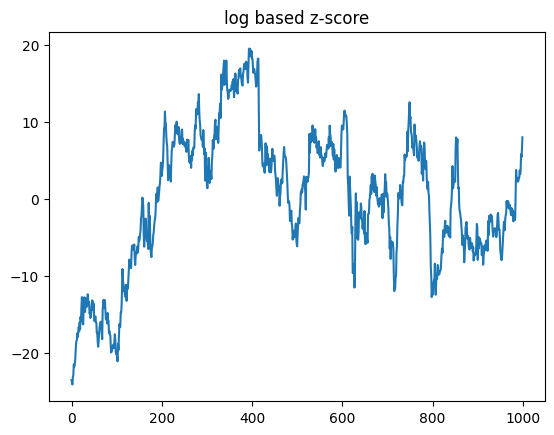

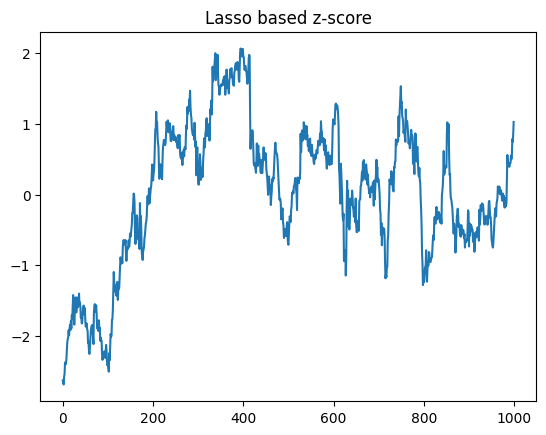

pairs = (['8801 JT', '8802 JT'])



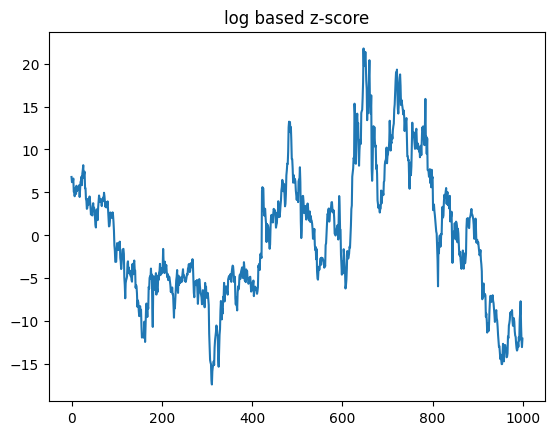

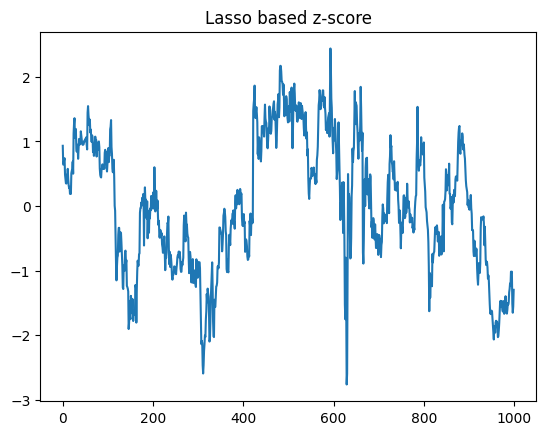

In [53]:
training_set_price = training_pair_set.drop(columns=['ticker'])

for i in range(len(pairs_list)):
    print("pairs = (" + str(pairs_list[i]) + ")\n")
    # Generate input for the test
    a = training_set_price.iloc[2*i].to_numpy()[1:]
    b = training_set_price.iloc[2*i+1].to_numpy()[1:]

    # Check the log based function on the log normalization
    spread_func = create_spread_function(a, b, 0, 1000, 'log')
    (spread, z_score) = spread_func(a[0], b[0])

    # Generate the graph about log based z_score
    x = np.arange(1000)
    z_score_history = np.zeros((1000))
    for i in range(1000):
        (spread, z_score_history[i]) = spread_func(a[i], b[i])
    plt.title('log based z-score')
    plt.plot(x, z_score_history)
    plt.show()

    # Check the Lasso based function on the linear regression
    spread_func = create_spread_function(a, b, 0, 1000, 'lr')
    (spread, z_score) = spread_func(a[0], b[0])

    # Generate the graph about log based z_score
    for i in range(1000):
        (spread, z_score_history[i]) = spread_func(a[i], b[i])
    plt.title('Lasso based z-score')
    plt.plot(x, z_score_history)
    plt.show()
    print("======================================================")

## Generate the z-score history list
We will generate the z-score list.
The spread function we will use is based on certain days previous price history (We will call this as 'window_width').
We will update the spread function every 'update_period' like a moving windows.
It will be used for our strategy to deciding when wewe will buy/sell the stocks.

In [ ]:
def gen_z_score_history(price_a, price_b, windows_width=800, spread_func_update_period=30):
    """
    Generate the z-scores history
    
    Args:
        price_a, price_b: stock's present price history dataset (T)
        windows_width: Width training data (day)
        spread_func_update_period: The period of spread function update (day)
    Return:
        z_score_list: z-score history (T-windows_width)
    """

    # Initialization
    T = len(price_a)
    z_score_list = np.zeros((T-windows_width))
    a = price_a
    b = price_b

    # Calculate the z_score one by one.
    for t in range(T-windows_width):

        # Generate the spread_function for every update_period
        if t % spread_func_update_period==0:
            spread_func = create_spread_function(
                a, b, t, t + windows_width, 'lr')
        
        # Generate the z-score with spread_function
        spread, z_score = spread_func(a[t], b[t])
        z_score_list[t] = z_score
    
    return z_score_list

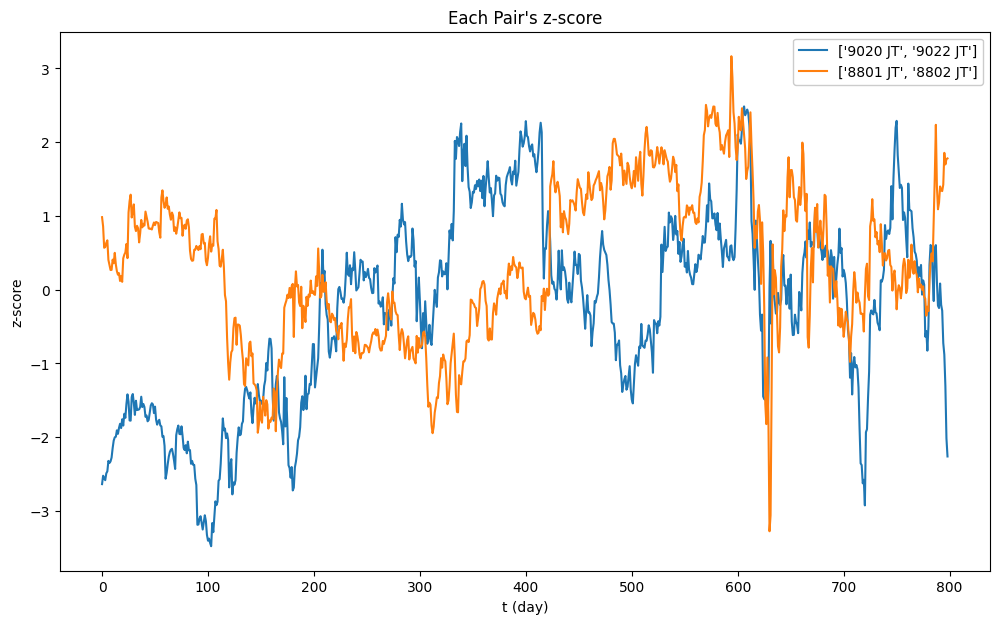

In [73]:
z_score_history_list = np.zeros((1, 1))
pairs_training_set = training_pair_set

# Run the z_score_history generation function for each pair.
for pair in pairs_list:

    # Generate the price_history table for each pair.
    price_history_a = pairs_training_set.loc[
        pairs_training_set['ticker'] == pair[0]].drop(columns=['ticker'])
    price_history_a = price_history_a.to_numpy()[0]
    price_history_b = pairs_training_set.loc[
        pairs_training_set['ticker'] == pair[1]].drop(columns=['ticker'])
    price_history_b = price_history_b.to_numpy()[0]

    # Run the z-score history generation function for each pair.
    try:
        z_score_history = gen_z_score_history(
            price_history_a, price_history_b)[np.newaxis]
        z_score_history_list = np.append(
            z_score_history_list, z_score_history, axis=0)
    except:
        z_score_history_list = gen_z_score_history(
            price_history_a, price_history_b)[np.newaxis]

plt.figure(figsize=(12, 7))
plt.title('Each Pair\'s z-score')
plt.ylabel('z-score')
plt.xlabel('t (day)')
x = np.arange(z_score_history_list[0].shape[0])
for i, pair in enumerate(pairs_list):
    plt.plot(x, z_score_history_list[i], label=str(pair))
plt.legend(framealpha=1, frameon=True, loc=1)
plt.savefig('each_pair_z_score.png')
plt.show()

with open('z_score_history.npy', 'wb') as outfile:
    np.save(outfile, z_score_history_list)